In [1]:
from pythonfiles.data_class import SemanticDataset
from pythonfiles.nn3 import pl_nn

In [2]:
from torch.utils.data import DataLoader
import os
import pytorch_lightning as pl
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
def best_test_values(model,test_dataloader):
    loss_list=np.zeros((len(test_data)))
    for i,data in enumerate(test_dataloader,0):
        image_i=data['image']
        labels_i=data['label']
        labels_i = 3*labels_i-1
        labels_i = labels_i.squeeze(1)
        labels_i = labels_i.to(dtype=torch.long)
        outputs_i=model_1.forward(image_i)
        loss_i=F.cross_entropy(outputs_i, labels_i)
        loss_list[i]=loss_i
        if(i%100==0):
            print("{:.0%}".format(i/len(test_data)))

    loss_list_sorted=np.sort(loss_list)
    loss_list_sorted=loss_list_sorted[0:10]
    loss_list_idx=np.zeros(10)
    for idx,item in enumerate(loss_list_sorted,0):
        for idx_full,item_full in enumerate(loss_list,0):
            if(item==item_full):
                loss_list_idx[idx]=idx_full

    print("Best Examples",loss_list_idx)   
    return loss_list_idx


In [4]:
def plotter(model_1,model_2,model_3,test_dataloader,idx):
    for i,image_data in enumerate(test_dataloader,0):
        if(i==idx):
            image=image_data['image']
            label=image_data['label']

    out_image_1=model_1.forward(image)    
    out_image_2=model_2.forward(image)    
    out_image_3=model_3.forward(image)    

    outputs_np_1=out_image_1.detach().numpy()
    outputs_idx_1=outputs_np_1[0,:,:,:]
    outputs_max_1=np.argmax(outputs_idx_1,axis=0)

    outputs_np_2=out_image_2.detach().numpy()
    outputs_idx_2=outputs_np_2[0,:,:,:]
    outputs_max_2=np.argmax(outputs_idx_2,axis=0)

    outputs_np_3=out_image_3.detach().numpy()
    outputs_idx_3=outputs_np_3[0,:,:,:]
    outputs_max_3=np.argmax(outputs_idx_3,axis=0)

    outputs_agg_1=(outputs_np_3[0,:,:,:]+outputs_np_2[0,:,:,:]+outputs_np_1[0,:,:,:])/3
    outputs_agg_max_1=np.argmax(outputs_agg_1,axis=0)

    outputs_agg_2_1=np.maximum(outputs_np_1[0,:,:,:],outputs_np_2[0,:,:,:])
    outputs_agg_2_2=np.maximum(outputs_agg_2_1,outputs_np_3[0,:,:,:])
    outputs_agg_max_2=np.argmax(outputs_agg_2_2,axis=0)

    image_label=label.detach().numpy()
    image_label=image_label[0,:,:]
    image_label=image_label.reshape(240,240)


    image_1=image.detach().numpy()
    image_2=image_1[0,:]
    image_5=image_2.transpose(1,2,0)

    plt.rcParams['figure.facecolor'] = 'white'
    fig, axs = plt.subplots(3, 2,figsize=(7,10),constrained_layout=True)
    gs1 = gridspec.GridSpec(4, 4)
    


    plt.subplots_adjust(wspace=0, hspace=0.1)

    
    axs[1, 0].imshow(outputs_max_1)
    axs[1, 0].set_title('Dropout 0')
    axs[1, 0].axis("off")


    axs[1, 1].imshow(outputs_max_2)
    axs[1, 1].set_title('Dropout 0.2')
    axs[1, 1].axis("off")

    axs[2, 0].imshow(outputs_max_3)
    axs[2, 0].set_title('Dropout 0.4')
    axs[2, 0].axis("off")

    axs[2, 1].imshow(outputs_agg_max_2)
    axs[2, 1].set_title('Ensemble Maximum')
    axs[2, 1].axis("off")

    axs[0, 1].imshow(image_label)
    axs[0, 1].set_title('Ground Truth')
    axs[0, 1].axis("off")

    axs[0, 0].imshow(image_5)
    axs[0, 0].set_title("Actual Image")
    axs[0, 0].axis('off')
   
    fig.savefig(str(idx)+".png",bbox_inches='tight')

In [5]:
hparams_1 = {"dropout_p": 0,
           "batch_size": 8,
           "filter_size_max": 512,
           "weight_decay": 0,
           "max_epochs": 25,
           "save_string": "512p0l20"
           }

hparams_2 = {"dropout_p": 0.2,
           "batch_size": 8,
           "filter_size_max": 512,
           "weight_decay": 0,
           "max_epochs": 25,
           "save_string": "512p2l20"
           }
hparams_3 = {"dropout_p": 0.4,
           "batch_size": 8,
           "filter_size_max": 512,
           "weight_decay": 0,
           "max_epochs": 25,
           "save_string": "512p4l20"
           }       


In [6]:
test_data=SemanticDataset(train=False,val=False,test=True,transform=None)
test_dataloader = DataLoader(test_data, batch_size=1,num_workers=6)

Loaded  735  Images


In [7]:
model_file_name_1='epoch25512p0l2028101407.ckpt'  
cp_save_dir_1=os.path.join(os.getcwd(),"CKP" ,model_file_name_1)
model_1=pl_nn(hparams=hparams_1)
model_1=model_1.load_from_checkpoint(cp_save_dir_1)
model_1.eval()
model_1.freeze()

model_file_name_2='epoch25512p2l2028101839-v0.ckpt'  
cp_save_dir_2=os.path.join(os.getcwd(),"CKP" ,model_file_name_2)
model_2=pl_nn(hparams=hparams_2)
model_2=model_1.load_from_checkpoint(cp_save_dir_2)
model_2.eval()
model_2.freeze()

model_file_name_3='epoch40512p4l2028102328.ckpt'  
cp_save_dir_3=os.path.join(os.getcwd(),"CKP" ,model_file_name_3)
model_3=pl_nn(hparams=hparams_3)
model_3=model_3.load_from_checkpoint(cp_save_dir_3)
model_3.eval()
model_3.freeze()



In [8]:
loss_list_idx=best_test_values(model_1,test_dataloader)

0%
14%
27%
41%
54%
68%
82%
95%
Best Examples [298. 233.  53.  95. 302. 395. 113. 658. 118.  69.]


In [9]:
  
#loss_list_idx=[298, 233,  53,  95, 302, 395, 113, 658, 118,  69]     

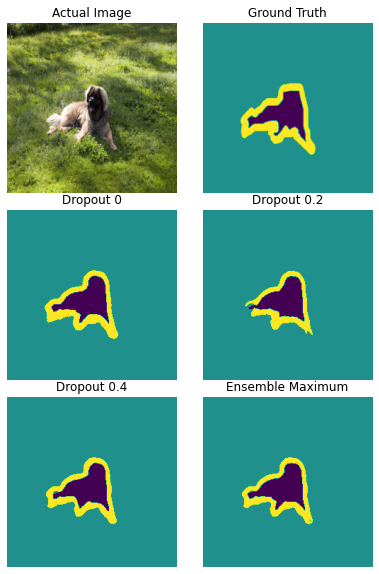

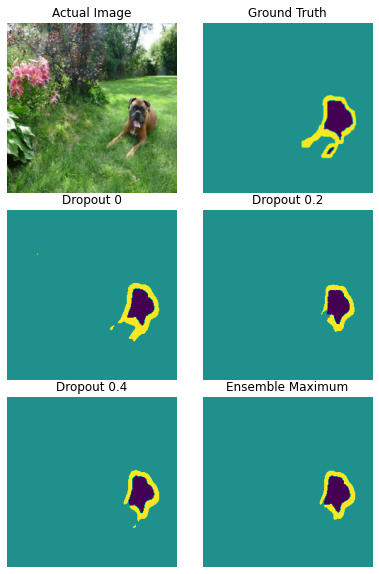

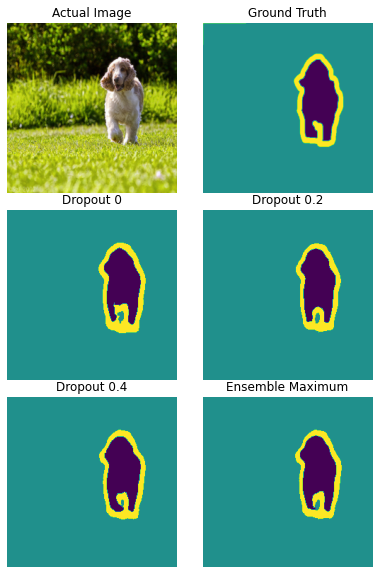

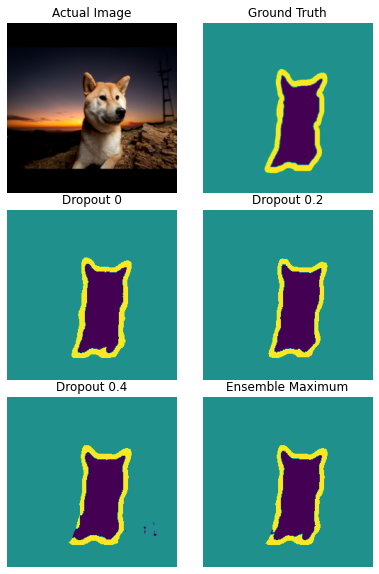

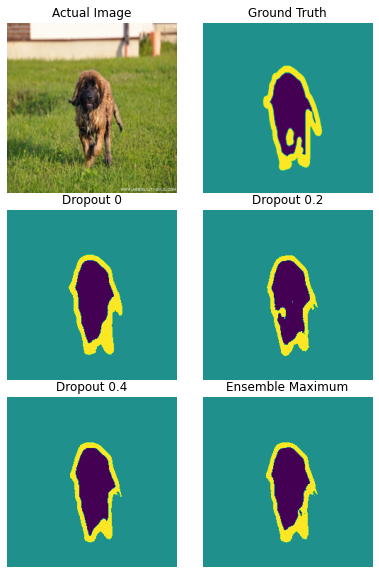

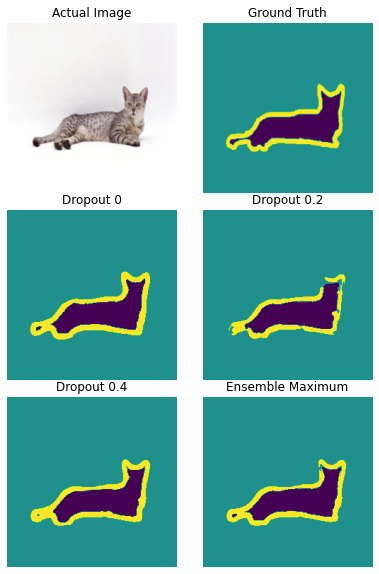

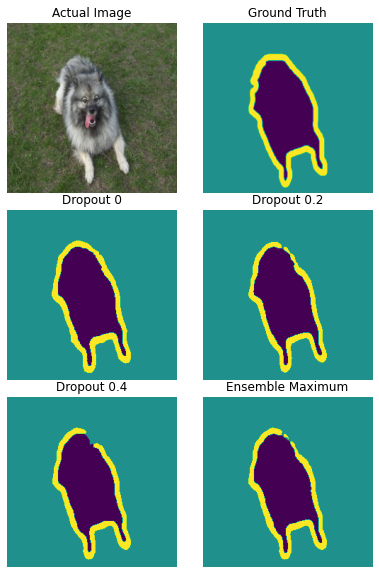

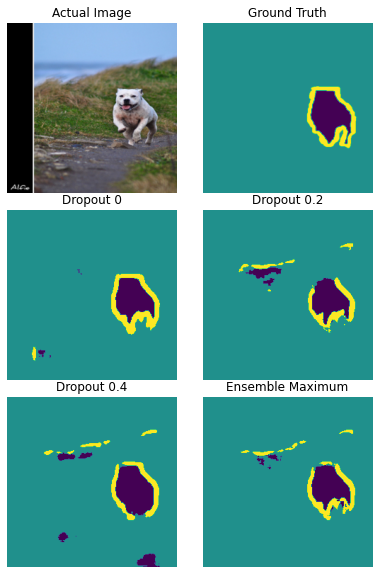

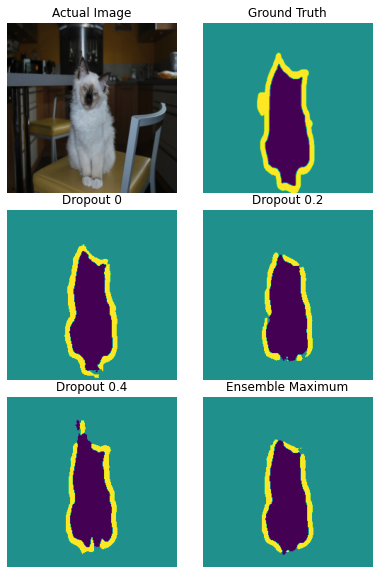

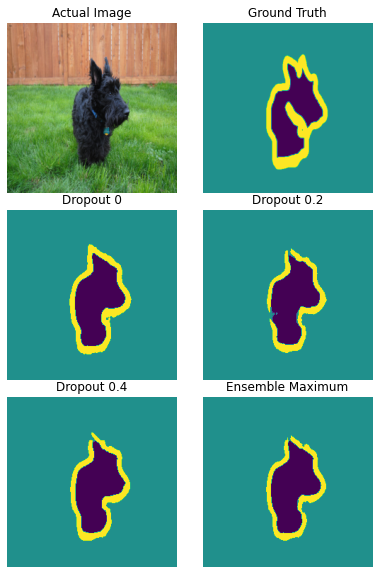

In [10]:
for item in loss_list_idx:
    plotter(model_1,model_2,model_3,test_dataloader,item)